# **CASE DATA MASTERS - DANILO SONODA**

**<font color = 'red'> O case Data Master - Cientista de Dados apresenta um problema de satisfação do cliente. É fornecida uma base com diversas variáveis numéricas e com a informação de satisfação do cliente (1 se insatisfeito e 0 se satisfeito). São solicitadas 3 tarefas:** <br>
**1)** Maximizar o lucro esperado por cliente dado os custos de ação de retenção e de sucesso. <br> 
**2)** Dar nota de 1 a 5 para os clientes respeitando a taxa de insatisfação dos mesmos. <br> 
**3)** Encontrar os 3 grupos naturais com maior lucro esperado por cliente

**Abaixo segue a minha resolução para o case:**

# **<font color='red'> Carrega/Instala Bibliotecas**

In [1]:
!pip install feature_engine
!pip install hyperopt
!pip install kneed

Looking in indexes: http://artifactory.produbanbr.corp/artifactory/api/pypi/pypi-all/simple
Looking in indexes: http://artifactory.produbanbr.corp/artifactory/api/pypi/pypi-all/simple
Looking in indexes: http://artifactory.produbanbr.corp/artifactory/api/pypi/pypi-all/simple


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap 

from collections import Counter
from feature_engine.selection import DropDuplicateFeatures, DropConstantFeatures
from hyperopt import fmin, tpe, hp, Trials
from kneed import KneeLocator
from numpy import random
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix, silhouette_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, cv, DMatrix

# **<font color='red'> Overview Base**

### Carrega base

In [3]:
df = pd.read_csv("../C/train.csv")
df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


### Verifica tamanho da base e resumo da distribuição das variáveis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [5]:
df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


### Separa variável resposta e dropa variável da base de features

In [6]:
y = df['TARGET']

In [7]:
df = df.drop(columns=['ID','TARGET'])
df["var3"].replace({-999999.000000: 2}, inplace=True)
df.shape

(76020, 369)

Neste passo foram observadas duas coisas. 1) Existe a variável 'ID' que é referente a identficação do cliente e sendo assim não trará discriminação para o modelo, por este motivo foi removida da base. 2) Pelo resumo das estatísticas foi possível observar que a variável 'var3' apresenta um valor distoante (-999999) que pode ser algum valor de erro ou filtro. Por este motivo estes valores foram substituídos pelo valor mais usual da variável (moda). 

# <font color='blue'> Análise da Target

In [8]:
y.value_counts()

0    73012
1     3008
Name: TARGET, dtype: int64

<AxesSubplot:ylabel='TARGET'>

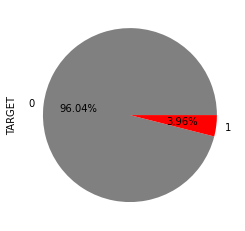

In [9]:
y.value_counts().plot.pie(autopct = '%1.2f%%', colors=['grey','red'])

**É possível observar que cerca de 4% da base é de clientes insatisfeitos e 96% de clientes satisfeitos**

# **<font color = 'red'> TRATAMENTO DA BASE**

# <font color='blue'> Verifica Missing

<AxesSubplot:>

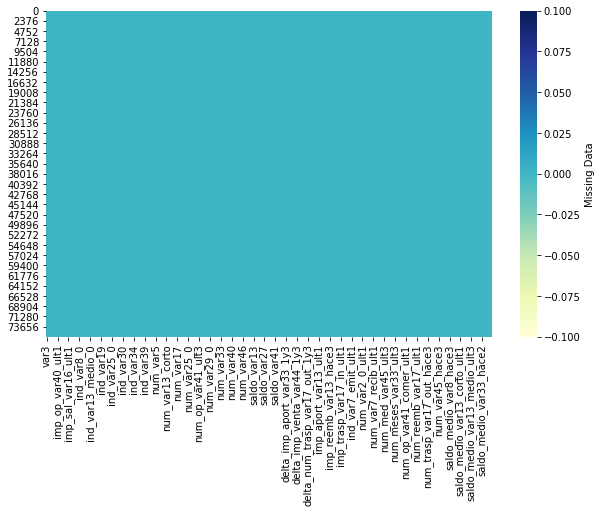

In [10]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isna(), cmap="YlGnBu",cbar_kws={'label': 'Missing Data'})

Não há informações faltantes na base. 

# <font color='blue'> Verifica Outlier

O critério adotado para detecção de outliers foi baseado na média e desvio padrão de cada variável, sendo que o tratamento considerado será a substituição do outlier pelos limites superior (cap) e inferior (floor). <br>
Os limites serão definidos da seguinte forma: <br>
$Floor = mean - 2.5 * std $ <br>
$Cap = mean + 2.5 * std$

In [11]:
mean = np.mean(df)
std = np.std(df)
floor = mean - 2.5*std
cap = mean + 2.5*std

In [12]:
for i in df.columns:
    df[i] = np.where(df[i] < floor[i], floor[i], df[i])
    df[i] = np.where(df[i] > cap[i], cap[i], df[i])

In [13]:
df.describe()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000
mean,2.232550,32.915476,48.050829,51.229826,86.185522,0.793394,1.486636,0.037749,0.053250,0.646158,...,0.003153,0.603148,0.082880,1.086403,0.753908,5.102302,0.149253,13.593422,10.100107,113064.168167
std,2.026413,11.990362,337.560807,179.133270,289.499217,13.302093,23.341544,1.691100,2.194593,12.199280,...,0.501827,26.091665,4.799873,45.569850,31.435433,155.855274,7.406325,354.803105,258.550369,74493.565148
min,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5163.750000
25%,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67870.612500
50%,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,106409.160000
75%,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,118756.252500
max,26.336255,65.603867,4123.074995,920.647065,1485.186385,236.446970,390.812834,76.924603,91.850535,241.329660,...,79.884651,1147.646373,286.262365,1970.221199,1354.873247,5064.285704,371.322605,10176.804334,7188.015939,573894.302116


# <font color='blue'> Verifica Variância Constante / Duplicado

Neste passo serão removidas as features que forem constantes (apresentarem o mesmo valor para todas as observações) e features duplicadas (features que apresentam valores exatamente iguais a outra feature). 

In [14]:
pipe = Pipeline([
                ('constant', DropConstantFeatures()), # Constante
                ('duplicated', DropDuplicateFeatures()), # Duplicado
                ])
pipe.fit(df)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('duplicated', DropDuplicateFeatures())])

In [15]:
print("Quantidade de features constantes:", len(pipe.named_steps['constant'].features_to_drop_))
print("Quantidade de features duplicadas", len(pipe.named_steps['duplicated'].features_to_drop_))

Quantidade de features constantes: 34
Quantidade de features duplicadas 29


In [16]:
print('Number of original variables: ', df.shape[1])

df = pipe.transform(df)

print('Number of variables after selection: ', df.shape[1])

Number of original variables:  369
Number of variables after selection:  306


**63 features foram removidas neste processo**

# **<font color = 'red'> Separa base de treino e teste**

Será realizada a separação da base de treino e teste na proporção 70/30. 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=14)

In [18]:
print("X_Train:" +str(X_train.shape))
print("y_train:" +str(y_train.shape))
print("X_test:" +str(X_test.shape))
print("y_test:" +str(y_test.shape))
# X_Train:(53214, 306)
# y_train:(53214,)
# X_test:(22806, 306)
# y_test:(22806,)

X_Train:(53214, 306)
y_train:(53214,)
X_test:(22806, 306)
y_test:(22806,)


In [19]:
print(Counter(y_train))

print(Counter(y_test))
# Counter({0: 51119, 1: 2095})
# Counter({0: 21893, 1: 913})

Counter({0: 51119, 1: 2095})
Counter({0: 21893, 1: 913})


# <font color='blue'> **TAREFA 1**

# **<font color = 'red'> Feature Selection**

Para a seleção de variáveis, será utilizada a função SelectFromModel para definir as variáveis do modelo de Random Forest que possuem feature importance maior do que um determinado threshold (nesta ocasião será considerada a média). 

In [20]:
rf_fs = RandomForestClassifier(random_state = 14)
sfm = SelectFromModel(rf_fs, threshold = 'mean')
sfm.fit(X_train,y_train)
sfm.transform(X_train) 

array([[3.10000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        6.00000000e+02, 5.80650000e+02, 2.01571950e+05],
       [2.40000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.57866300e+05],
       [2.40000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        3.00000000e+00, 2.85000000e+00, 1.17310979e+05],
       ...,
       [2.30000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.26139800e+05],
       [2.30000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        3.00000000e+00, 2.07000000e+00, 1.26790590e+05],
       [4.60000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.60263300e+04]])

In [21]:
selected_vars = X_train.columns[sfm.get_support()]
selected_vars

Index(['var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var41_comer_ult3',
       'imp_op_var41_efect_ult3', 'imp_op_var41_ult1',
       'imp_op_var39_efect_ult3', 'imp_op_var39_ult1', 'num_var4', 'num_var35',
       'saldo_var5', 'saldo_var30', 'saldo_var37', 'saldo_var42', 'var36',
       'imp_trans_var37_ult1', 'num_var22_hace2', 'num_var22_hace3',
       'num_var22_ult1', 'num_var22_ult3', 'num_med_var22_ult3',
       'num_med_var45_ult3', 'num_meses_var5_ult3', 'num_meses_var39_vig_ult3',
       'num_var45_hace2', 'num_var45_hace3', 'num_var45_ult1',
       'num_var45_ult3', 'saldo_medio_var5_hace2', 'saldo_medio_var5_hace3',
       'saldo_medio_var5_ult1', 'saldo_medio_var5_ult3', 'var38'],
      dtype='object')

In [22]:
X_train_fs = X_train[selected_vars]
X_train_fs.shape
# (53214, 34)

(53214, 34)

A partir do processo descrito, foram selecionadas 34 variáveis para o modelo final. 

# **<font color = 'red'> Escola do Modelo**

Serão comparados diferentes tipos de modelos (Árvore de Decisão (DT), Random Forest(RF) e XGBoost(XGB)) e será selecionado o modelo com melhor perfomance de AUC. 

In [23]:
DT = DecisionTreeClassifier(max_depth = 6, class_weight = "balanced", random_state = 14)
RF = RandomForestClassifier(max_depth = 6, class_weight = "balanced", random_state = 14)
XGB = XGBClassifier(scale_pos_weight = sum(y_train == 0) / sum(y_train == 1), random_state=14)

Para evitar casos de overfit, limitou-se a profundidade máxima da árvore à 6 (o default do XGBoost). Além disso, incluiu-se o parâmetro de balanceamento dado que vimos que a base é desbalanceada (4% de target e 96% dos demais).

In [24]:
DT.fit(X_train_fs,y_train)
predito_DT = DT.predict(X_train_fs)
predito_DT_T = DT.predict(X_test[selected_vars])
auc_DT = roc_auc_score(y_train, predito_DT)
auc_DT_T = roc_auc_score(y_test, predito_DT_T)
print("AUC DT:", auc_DT)
print("AUC DT (teste):", auc_DT_T)

RF.fit(X_train_fs,y_train)
predito_RF = RF.predict(X_train_fs)
predito_RF_T = RF.predict(X_test[selected_vars])
auc_RF = roc_auc_score(y_train, predito_RF)
auc_RF_T = roc_auc_score(y_test, predito_RF_T)
print("AUC RF:", auc_RF)
print("AUC RF (teste):", auc_RF_T)

XGB.fit(X_train_fs,y_train)
predito_XGB = XGB.predict(X_train_fs)
predito_XGB_T = XGB.predict(X_test[selected_vars])
auc_XGB = roc_auc_score(y_train, predito_XGB)
auc_XGB_T = roc_auc_score(y_test, predito_XGB_T)
print("AUC XGB:", auc_XGB)
print("AUC XGB (teste):", auc_XGB_T)

AUC DT: 0.7781411112383614
AUC DT (teste): 0.7515395624512309
AUC RF: 0.7746095275561105
AUC RF (teste): 0.7526357782441726
AUC XGB: 0.7867016131249929
AUC XGB (teste): 0.758114630907497


**A partir das métricas obtidas, decidi por escolher o modelo XGBoost para continuidade às análises**

# **<font color = 'red'> Definir Hiperparâmetros**

Para definir os hiperparâmetros do modelo, decidi por realizar o hyperopt com CV para o XGBoost maximizando a métrica AUC (minimizando -AUC). Abaixo segue o espaço de hiperparâmetros definido. 

### Espaço de Parâmetros

In [25]:
space = {
    'eta' : hp.uniform('eta',0.01, 0.3),
    'gamma' : hp.quniform('gamma',0, 0.3, 0.05),
    'max_depth' : hp.quniform('max_depth', 3, 10, 2),
    'n_estimators' : hp.quniform('n_estimators', 10, 100, 10),
    'lambda' : hp.uniform('lambda', 1, 5), 
    'alpha' : hp.uniform('alpha', 0, 5),
    'min_child_weight': hp.uniform('min_child_weight', 1, 100),
    'scale_pos_weight': hp.quniform('scale_pos_weight',1, sum(y_train == 0) / sum(y_train == 1), 1)
}

### Função Objetivo

In [26]:
def objetivo(space):
    params = {"eta": space['eta'],
                "gamma": space['gamma'],
                "max_depth": int(space['max_depth']),
                "n_estimators": int(space['n_estimators']),
                "reg_lambda": space['lambda'],
                "reg_alpha": space['alpha'],
                "min_child_weight": space['min_child_weight']
             }
    
    X_CV_train = DMatrix(X_train_fs, y_train)
    cv_results = cv(dtrain = X_CV_train, params = params, nfold = 3, num_boost_round = 100, early_stopping_rounds = 5, metrics = "auc", as_pandas = True, seed = 14)
  
    best_score = max(cv_results['test-auc-mean'])
    print("AUC:" +str('{:0.2%}'.format(best_score)))
    
    loss = 1 - best_score
    return loss

### Roda o algoritmo

In [27]:
trials = Trials()
params_final_model = fmin(objetivo,
    space=space,
    algo=tpe.suggest,
    trials = trials,
    max_evals=100)

AUC:82.93%                                             
AUC:83.30%                                                                        
AUC:83.15%                                                                        
AUC:82.74%                                                                        
AUC:82.43%                                                                        
AUC:82.97%                                                                        
AUC:83.15%                                                                        
AUC:82.25%                                                                        
AUC:82.82%                                                                        
AUC:83.23%                                                                        
AUC:82.99%                                                                         
AUC:83.26%                                                                         
AUC:82.54%                   

 # <font color='red'> **Modelo Final**

Após a tunagem dos hiperparâmetros, utiliza-se os parâmetros finais para gerar o modelo final. 

In [28]:
final_model = XGBClassifier(
                            eta = params_final_model['eta'],
                            gamma = params_final_model['gamma'],
                            max_depth = params_final_model['max_depth'].astype('int'),
                            n_estimators = params_final_model['n_estimators'].astype('int'),
                            reg_lambda = params_final_model['lambda'],
                            reg_alpha = params_final_model['alpha'],
                            min_child_weight = params_final_model['min_child_weight'],
                            scale_pos_weight = params_final_model['scale_pos_weight'] # (sum(y_train == 0) / sum(y_train == 1)),
                            )

final_model.fit(X_train_fs,y_train)

predito_final = final_model.predict(X_train_fs)
auc_final = roc_auc_score(y_train, predito_final)
print("AUC Final:", auc_final)

predito_final_t = final_model.predict(X_test[selected_vars])
auc_final_t = roc_auc_score(y_test, predito_final_t)
print("AUC Final (teste):", auc_final_t)

AUC Final: 0.8007647698913589
AUC Final (teste): 0.7536368634285172


# SHAP

A partir do SHAP é possível observar as variáveis com maior importância para o modelo

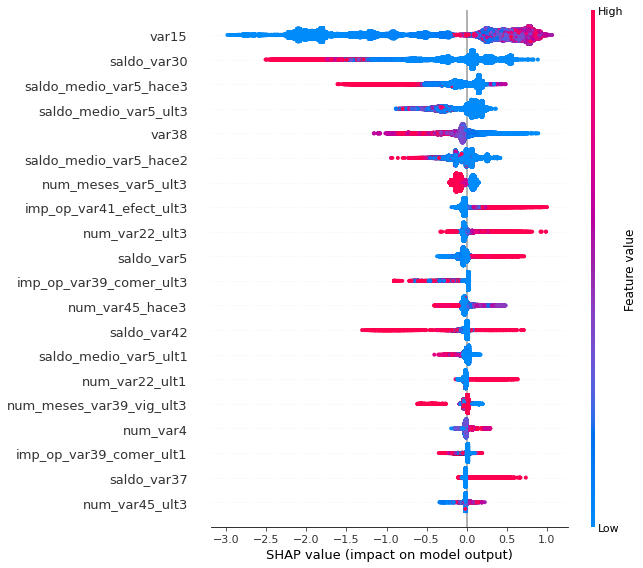

In [29]:
pred = final_model.predict(X_train_fs, output_margin=True)
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train_fs)
shap.summary_plot(shap_values, X_train_fs)

 ## Customização do ponto de corte

Após obter o modelo final, o próximo passo é fazer uma análise de threshold para definir o ponto de corte do predict_proba para classificar os clientes em 'Insatisfeitos' e 'Satisfeitos'. Para isso será percorrido um laço de 1% em 1% e irá verificar o valor de predict_proba onde se maximiza o lucro esperado por cliente. Cabe relembrar que para cada cliente que for alvo da ação de retenção há um custo de 10 reais e para cada cliente 'Insatisfeito' que for alvo de ação há um lucro de 100 reais. 

In [30]:
prob_treino = final_model.predict_proba(X_train_fs)[:,1]
customiza_thresh = pd.DataFrame({'Probabilidade' : prob_treino, 'Bad' : y_train})

In [31]:
resumo_metricas = []
max_lucro_train = y_train.sum()*90

# Iteranto sobre os pontos de corte de interesse.
for corte in np.arange(0.01, 1, 0.01):
    
    # Cria o predict baseado no valor do corte
    customiza_thresh['bad_thresh'] = (customiza_thresh['Probabilidade'] >= corte).astype('int')
    
    # Calcula precision e recall
    precision = precision_score(customiza_thresh['Bad'], customiza_thresh['bad_thresh'])
    recall = recall_score(customiza_thresh['Bad'], customiza_thresh['bad_thresh'])
    
    # Calcula Matriz de Confusão
    CM = confusion_matrix(customiza_thresh['Bad'], customiza_thresh['bad_thresh'])
    
    # Calcula o lucro por cliente
    lucro = CM[1,1]*90 - CM[0,1]*10
    perc_max_lucro = lucro / max_lucro_train
    
    # Apendando resultados na lista
    resumo_metricas.append([corte, precision, recall, lucro, perc_max_lucro])

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [32]:
resumo_metricas = pd.DataFrame(resumo_metricas, columns=["corte", "precision", "recall", "lucro", "perc_max_lucro"])
resumo_metricas.loc[resumo_metricas.lucro == max(resumo_metricas['lucro'])]

,corte,precision,recall,lucro,perc_max_lucro
64,0.65,0.188065,0.645346,63310,0.335773


In [33]:
corte_otimo = resumo_metricas.loc[resumo_metricas.lucro == max(resumo_metricas['lucro'])]['corte'].values[0]
corte_otimo

0.65

A partir da análise realizada, é possível observar que o ponto de corte para se maximizar o lucro é no predict_proba = 0.65

## Aplicando ponto de corte ideal na base de teste

In [34]:
prob_teste = final_model.predict_proba(X_test[selected_vars])[:,1]
base_teste_final = pd.DataFrame({'Probabilidade' : prob_teste, 'Bad' : y_test})
base_teste_final['Bad_Final'] = (base_teste_final['Probabilidade'] >= corte_otimo).astype('int')

CM = confusion_matrix(base_teste_final['Bad'], base_teste_final['Bad_Final'])
lucro = CM[1,1]*90 - CM[0,1]*10
max_lucro_test = y_test.sum()*90
perc_max_lucro = lucro / max_lucro_test

print("Lucro: ", lucro)
print("%Lucro:{:0.2%}".format(perc_max_lucro))

Lucro:  22280
%Lucro:27.11%


**Aplicando o ponto de corte encontrado na base de treino, aplicou-se na base de teste e foi possível observar um lucro de 22.280 reais.**

# <font color='blue'> **TAREFA 2**

O objetivo da tarefa 2 é dar nota (rating) de 1 a 5 para os clientes, sendo 1 o mais insatisfeitos e 5 os mais satisfeitos. Além disso, somente os clientes com nota 1 serão alvos da ação de retenção. Por fim, tem-se que maximizar o lucro esperado por cliente. 

## Gera base para análise

In [35]:
tarefa_2 = X_train_fs.copy()
tarefa_2['predict'] = final_model.predict_proba(tarefa_2)[:,1]
tarefa_2['score'] = ((1-tarefa_2['predict'])*1000).astype('int')
tarefa_2['TARGET'] = y_train

## Verifica distribuição do score para clientes satisfeitos e insatisfeitos

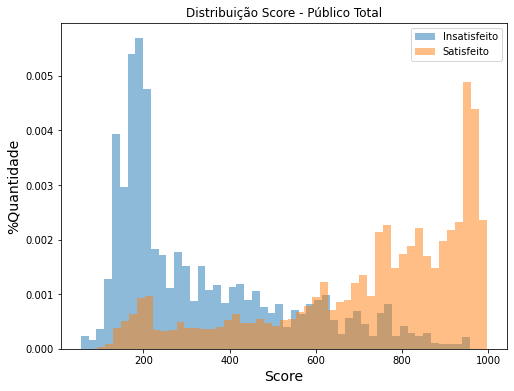

In [36]:
plt.figure(figsize=(8,6))
plt.hist(tarefa_2.loc[(tarefa_2.TARGET == 1)]['score'], bins=50, density = True ,  alpha=0.5, label="Insatisfeito")
plt.hist(tarefa_2.loc[(tarefa_2.TARGET == 0)]['score'], bins=50, density = True , alpha=0.5, label="Satisfeito")

plt.xlabel("Score", size=14)
plt.ylabel("%Quantidade", size=14)
plt.title("Distribuição Score - Público Total")
plt.legend(loc='upper right')

## Separa clientes alvo da ação de retenção (Rating 1)

Aplica um laço para verificar o score em que pode ser feito o corte para definir o público alvo da ação de retenção de forma a se obter o máximo de lucro. 

In [37]:
resumo = []

# Iteranto sobre os pontos de corte de interesse.
for corte in np.arange(100, 1000, 10):
    
    qtdd = tarefa_2.loc[tarefa_2.score <= corte].shape[0]
    bads = tarefa_2.loc[tarefa_2.score <= corte]['TARGET'].sum()
    lucro = 100*bads - 10*qtdd
    
    # Apendando na lista
    resumo.append([corte, lucro, qtdd, bads])

In [38]:
resumo_df = pd.DataFrame(resumo, columns = ["Score","Lucro","Quantidade","Bads"])
max_lucro = resumo_df.loc[resumo_df.Lucro == max(resumo_df['Lucro'])]
max_lucro

,Score,Lucro,Quantidade,Bads
25,350,63280,7202,1353


In [39]:
score_max_lucro = max_lucro['Score'].values[0]
score_max_lucro

350

### Separa base com clientes Rating 1

In [40]:
rating_1 = tarefa_2[tarefa_2['score'] <= score_max_lucro]
rating_1['rating'] = '1'
rating_1


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var41_comer_ult3,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,num_var4,...,num_var45_ult3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,var38,predict,score,TARGET,rating
69087,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.00,0.0,0.00,0.00,62932.560000,0.828639,171,0,1
46700,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.00,0.00,89379.720000,0.814648,185,1,1
49212,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,0.00,0.0,0.00,0.00,90061.020000,0.820125,179,0,1
67626,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.00,0.00,63649.020000,0.838962,161,0,1
42549,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.00,0.00,75486.150000,0.784274,215,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43533,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.00,0.00,56829.030000,0.830073,169,0,1
8771,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.00,0.00,117310.979016,0.699345,300,0,1
9848,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.00,0.00,119907.210000,0.718140,281,0,1
55964,52.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,6.0,2.88,0.0,31.77,17.34,95851.440000,0.697234,302,0,1


## Separa clientes para os demais Ratings (2 a 5)

In [41]:
rating_2a5 = tarefa_2[tarefa_2['score'] > score_max_lucro]

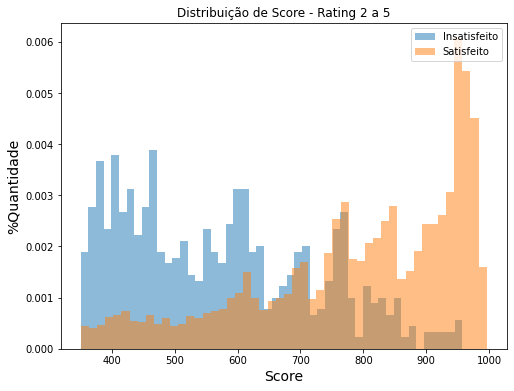

In [42]:
plt.figure(figsize=(8,6))
plt.hist(rating_2a5.loc[(rating_2a5.TARGET == 1)]['score'], bins=50, density = True ,  alpha=0.5, label="Insatisfeito")
plt.hist(rating_2a5.loc[(rating_2a5.TARGET == 0)]['score'], bins=50, density = True , alpha=0.5, label="Satisfeito")

plt.xlabel("Score", size=14)
plt.ylabel("%Quantidade", size=14)
plt.title("Distribuição de Score - Rating 2 a 5")
plt.legend(loc='upper right')

A partir do gráfico, é possível observar que conforme aumenta o score, a taxa de insatisfação diminui. Desta forma, para determinar os ratings 2 a 5 será realizado uma separação do público restante em quartis. Desta forma, não haverá concentração de público em um determinado rating e, principalmente, haverá a ordenação na taxa de insatisfação. 

In [43]:
rating_2a5['rating'], bins = pd.qcut(rating_2a5['score'], q = 4, labels = ['2','3','4','5'], retbins = True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<AxesSubplot:xlabel='rating'>

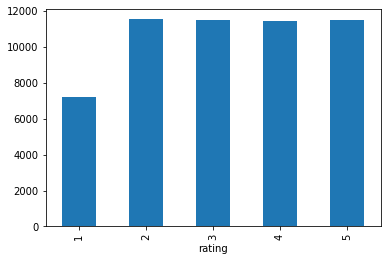

In [44]:
tarefa_2_final = pd.concat([rating_1, rating_2a5])
tarefa_2_final.sort_values(['rating']).groupby(['rating']).size().plot.bar()

O gráfico acima mostra a distribuição de clientes em cada rating

In [45]:
score_to_rating = tarefa_2_final.groupby(['rating']).agg(['max'])['score']
bins_ratings = score_to_rating['max'].values
bins_ratings

array([350, 685, 824, 936, 996])

In [46]:
conditions = [
                (tarefa_2_final['score'] <= score_max_lucro),
                (tarefa_2_final['score'] > score_max_lucro)
            ]

values = [tarefa_2_final['TARGET']*100 - (tarefa_2_final['score'] <= score_max_lucro)*10, 0]
tarefa_2_final['lucro'] = np.select(conditions, values)
tarefa_2_final.groupby(['rating']).agg(['mean','sum'])['lucro']

,mean,sum
rating,,
1,8.786448,63280
2,0.000000,0
3,0.000000,0
4,0.000000,0
5,0.000000,0


É possível observar que a partir dos ratings assignados no processo anterior, haverá um lucro de 63.280 reais na base de treino. A seguir iremos aplicar estes mesmos cortes na base de teste. 

## Aplica classificação de ratings na base de teste

In [47]:
base_teste = X_test[selected_vars]
base_teste['predict'] = final_model.predict_proba(base_teste)[:,1]
base_teste['score'] = ((1-base_teste['predict'])*1000).astype('int')
base_teste['TARGET'] = y_test
base_teste['rating'] = pd.cut(base_teste['score'], bins = np.append(0,bins_ratings) ,labels=['1','2','3','4','5'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

<AxesSubplot:xlabel='rating'>

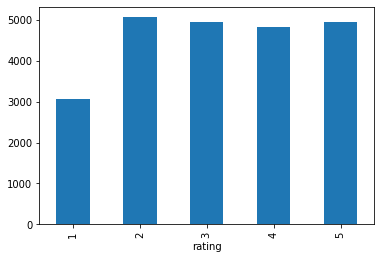

In [48]:
base_teste.sort_values(['rating']).groupby(['rating']).size().plot.bar()

Pelo gráfico acima é possível observar um comportamento similar ao observado na base treino. Com os ratings 2 a 5 com proporções similares de clientes e os clientes de rating 1 com menor concentração. 

In [49]:
conditions = [
                (base_teste['score'] <= score_max_lucro),
                (base_teste['score'] > score_max_lucro)
            ]

values = [base_teste['TARGET']*100 - (base_teste['score'] <= score_max_lucro)*10, 0]
base_teste['lucro'] = np.select(conditions, values)
base_teste.groupby(['rating']).agg(['mean','sum'])['lucro']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,sum
rating,,
1,7.293233,22310
2,0.000000,0
3,0.000000,0
4,0.000000,0
5,0.000000,0


A partir da tabela acima é possível observar que com os ratings definidos anteriormente, tem-se um lucro de 22.310 reais na base de teste. 

In [50]:
base_teste.groupby(['rating']).agg(['mean','sum'])['TARGET']

,mean,sum
rating,,
1,0.172932,529
2,0.047468,240
3,0.019044,94
4,0.008520,41
5,0.001821,9


Ademais, conforme mencionado anteriormente, é possível observar que conforme aumenta o score, a taxa média de insatisfação diminui, sendo de 17% no rating 1 e 0,18% no rating 5. 

# <font color='blue'> **TAREFA 3**

A última tarefa solicitada foi encontrar os 3 grupos naturais com maior lucro esperado por cliente. Para esta tarefa será utilizado o algoritmo de clusterização K-Means. Dado que este algoritmo se baseia na distância euclidiana, será aplicado um pré processamento para que todas as features tenham a mesma escala, para que uma não tenha um peso maior que a outra. Além disso, será utilizado o algoritmo de PCA (Principal Componentes Analysis) para reduzir a dimensionalidade da base, uma vez que esse algoritmo sofre da maldição da dimensionalidade. 

## Carrega Base

In [51]:
tarefa_3 = df[selected_vars]
tarefa_3.describe()

,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var41_comer_ult3,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,num_var4,...,num_meses_var39_vig_ult3,num_var45_hace2,num_var45_hace3,num_var45_ult1,num_var45_ult3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,var38
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000
mean,32.915476,48.050829,51.229826,86.185522,81.558818,83.909842,104.114464,84.193138,106.417009,1.064731,...,1.592791,4.578299,3.320674,3.523443,11.832102,976.425628,541.760228,661.375594,686.366667,113064.168167
std,11.990362,337.560807,179.133270,289.499217,273.986398,352.342554,351.991883,353.401210,358.533582,0.861929,...,0.719655,9.361333,6.833144,8.363389,21.919998,4322.863335,3033.712663,2903.329630,2829.673391,74493.565148
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-128.370000,-8.040000,-922.380000,-476.070000,5163.750000
25%,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67870.612500
50%,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.990000,3.000000,2.730000,106409.160000
75%,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,2.000000,3.000000,3.000000,3.000000,12.000000,90.000000,12.217500,90.000000,83.790000,118756.252500
max,65.603867,4123.074995,920.647065,1485.186385,1393.435570,2488.425430,1881.512781,2497.723290,1922.309858,3.353339,...,3.000000,41.633213,29.936278,40.379472,96.910588,31950.066549,25612.695764,25114.366120,21523.593910,573894.302116


## Pré-Processamento

**Aplica-se a padronização dos dados para que todas as features estejam na mesma escala, assim evita-se que features com ranges de valor maior tenham maior peso no processo de clusterização, uma vez que será utilizada o K-Means e este depende da distância entre observações.**

In [52]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(tarefa_3)
scaled_features

array([[-0.82695933, -0.14234812, -0.2859891 , ..., -0.2278005 ,
        -0.24256198, -0.99148811],
       [ 0.09045023, -0.14234812, -0.2859891 , ..., -0.2278005 ,
        -0.24256198, -0.85626936],
       [-0.82695933, -0.14234812, -0.2859891 , ..., -0.2267672 ,
        -0.24183044, -0.61388791],
       ...,
       [-0.82695933, -0.14234812, -0.2859891 , ..., -0.2267672 ,
        -0.24150178, -0.52402211],
       [-0.66015759, -0.14234812, -0.2859891 , ..., -0.2267672 ,
        -0.24165021, -0.38642529],
       [ 1.09126065, -0.14234812, -0.2859891 , ..., -0.2278005 ,
        -0.24256198,  0.05700947]])

In [53]:
pca = PCA()
pca.fit(scaled_features)
pca.explained_variance_ratio_

array([2.99996769e-01, 1.23737701e-01, 7.54577941e-02, 5.78681116e-02,
       5.26543044e-02, 4.45933524e-02, 3.54450505e-02, 3.38773847e-02,
       2.91454626e-02, 2.87703566e-02, 2.77898531e-02, 2.57124221e-02,
       2.49361744e-02, 2.20438585e-02, 2.05338081e-02, 1.62986090e-02,
       1.35626684e-02, 1.23059120e-02, 1.03979394e-02, 8.38352155e-03,
       7.47552903e-03, 6.43469839e-03, 5.78330246e-03, 5.50964502e-03,
       3.65980642e-03, 2.72880594e-03, 2.29571885e-03, 8.40109331e-04,
       7.07620482e-04, 5.81070515e-04, 2.38202283e-04, 1.10664892e-04,
       1.00762765e-04, 2.30099558e-05])

Text(0, 0.5, 'Variância Explicativa Acumulada')

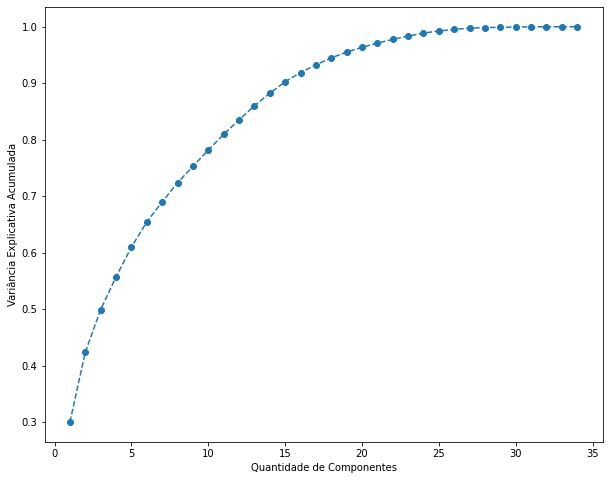

In [54]:
plt.figure(figsize = (10,8))
plt.plot(range(1, (len(pca.explained_variance_ratio_)+1)), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.xlabel('Quantidade de Componentes')
plt.ylabel('Variância Explicativa Acumulada')

Serão selecionados os 10 primeiros componentes principais, uma vez que estes somam cerca de 80% da variância. Assim reduz-se a dimensionalidade da base. 

In [55]:
pca = PCA(n_components = 10)
pca.fit(scaled_features)
scores_pca = pca.transform(scaled_features)

## Gera Clusters

Será utilizado o algoritmo de K-Means para a clusterização. Para definir o valor de K, serão simulados diversos modelos e será utilizado o Método do Cotovelo. 

In [56]:
wcss = []

for k in range(2, 15):
    print("Quantidade de Clusters:", k)
    kmeans = KMeans(n_clusters = k, init = "k-means++", n_init = 15,  random_state = 14)
    kmeans.fit(scores_pca)
    wcss.append(kmeans.inertia_)
    print("Fim:", k)

Quantidade de Clusters: 2
Fim: 2
Quantidade de Clusters: 3
Fim: 3
Quantidade de Clusters: 4
Fim: 4
Quantidade de Clusters: 5
Fim: 5
Quantidade de Clusters: 6
Fim: 6
Quantidade de Clusters: 7
Fim: 7
Quantidade de Clusters: 8
Fim: 8
Quantidade de Clusters: 9
Fim: 9
Quantidade de Clusters: 10
Fim: 10
Quantidade de Clusters: 11
Fim: 11
Quantidade de Clusters: 12
Fim: 12
Quantidade de Clusters: 13
Fim: 13
Quantidade de Clusters: 14
Fim: 14


## Escolha de K

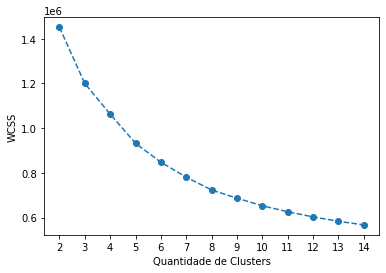

In [57]:
plt.plot(range(2, 15), wcss, marker = 'o', linestyle = '--')
plt.xticks(range(2, 15))
plt.xlabel("Quantidade de Clusters")
plt.ylabel("WCSS")
plt.show()

**A partir do método do "cotovelo" não foi possível chegar a conclusão pois não é claro o ponto de inflexão na curva, podendo ser entre k= 4 ou 5. Assim será calculado o coeficiente de silhueta para auxiliar a definir o valor de k**

In [59]:
silhouette_coefficients = []

for k in range(2, 7):
    print("Quantidade de Clusters:", k)
    kmeans = KMeans(n_clusters = k, init = "k-means++", n_init = 10,  random_state = 14)
    kmeans.fit(scores_pca)
    score = silhouette_score(scores_pca, kmeans.labels_)
    silhouette_coefficients.append(score)
    
    print("Fim:", k)

Quantidade de Clusters: 2
Fim: 2
Quantidade de Clusters: 3
Fim: 3
Quantidade de Clusters: 4
Fim: 4
Quantidade de Clusters: 5
Fim: 5
Quantidade de Clusters: 6
Fim: 6


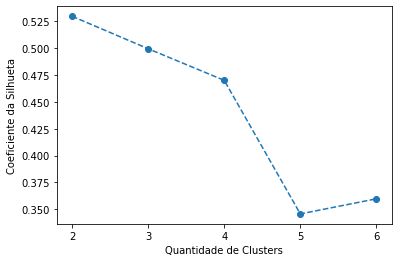

In [60]:
plt.plot(range(2, 7), silhouette_coefficients, marker = 'o', linestyle = '--')
plt.xticks(range(2, 7))
plt.xlabel("Quantidade de Clusters")
plt.ylabel("Coeficiente da Silhueta")
plt.show()

**A partir do método do cotovelo e do coeficiente da silheuta, decidi por definir o valor de k = 4.**

In [68]:
modelo_kmeans_final = KMeans(n_clusters=4, init = "k-means++", n_init=10,  random_state = 14)
modelo_kmeans_final.fit(scores_pca)

KMeans(n_clusters=4, random_state=14)

## Verifica clusterização

In [69]:
cluster = modelo_kmeans_final.fit_predict(scores_pca)
temp_cluster = tarefa_3.copy()
temp_cluster['cluster'] = cluster
temp_cluster['TARGET'] = y

## Verifica lucro por cluster

Inclui variáveis de target e predito do modelo final

In [70]:
predict_base_total = final_model.predict_proba(tarefa_3)[:,1]
temp_cluster['predict'] = predict_base_total
temp_cluster['predito'] = (temp_cluster['predict'] >= corte_otimo).astype('int')
temp_cluster

,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var41_comer_ult3,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,num_var4,...,num_var45_ult3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,var38,cluster,TARGET,predict,predito
0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00000,0.00,39205.170000,0,0,0.377561,0
1,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.00,88.89,0.00000,0.00,49278.030000,0,0,0.362964,0
2,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,3.00,0.18,3.00000,2.07,67333.770000,0,0,0.054120,0
3,37.0,0.0,195.0,195.0,195.0,0.0,195.0,0.0,195.0,3.0,...,48.0,186.09,0.00,91.56000,138.84,64007.970000,1,0,0.233513,0
4,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,3.00,0.30,25114.36612,13501.47,117310.979016,3,0,0.033902,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76015,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00000,0.00,60926.490000,0,0,0.838962,1
76016,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,48.0,130.65,0.00,0.00000,0.00,118634.520000,1,0,0.198039,0
76017,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,3.00,0.00,3.00000,3.00,74028.150000,0,0,0.084569,0
76018,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,3.00,1.74,3.00000,2.58,84278.160000,0,0,0.194325,0


## Cria variável de lucro para cada cliente

In [71]:
conditions = [
                (temp_cluster['predito'] == 1),
                (temp_cluster['predito'] == 0)
            ]
values = [temp_cluster['TARGET']*100 - temp_cluster['predito']*10, 0]
temp_cluster['lucro'] = np.select(conditions, values)

## Verifica distribuição de clientes e lucro por cluster

In [73]:
temp_cluster.groupby(temp_cluster['cluster']).agg(['count', 'sum','mean'])['lucro']

,count,sum,mean
cluster,,,
0,56465,67500,1.195431
1,13111,8120,0.619327
2,4765,9970,2.092340
3,1679,0,0.000000


<AxesSubplot:xlabel='cluster'>

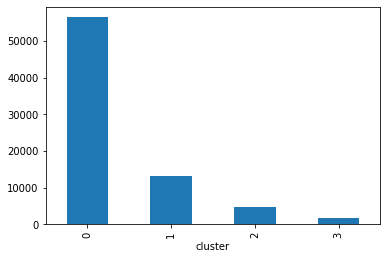

In [74]:
temp_cluster.sort_values(['cluster']).groupby(['cluster']).size().plot.bar()

A partir da distribuição de clientes é possível observar que há uma alta concentração no cluster 0 e uma baixa concentração, principalmente, no cluster 3. <br>
Com relação ao lucro esperado por cliente, o cluster com maior lucro esperado é o cluster 2 com média de lucro de 2.09 reais/cliente, seguido do cluster 1 com 1.19 reais/cliente e o terceiro cluster com maior lucro é o cluster 1 com 0.61 reais/cliente. Cabe destacar que não houve nenhum cluster com prejuízo, por outro lado, o cluster 3 não apresentou nenhum caso de ação de retenção. 